In [1]:
import mdtraj as md
import pyemma

import numpy as np
import pandas as pd

import os,sys
import pickle

import matplotlib
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *

In [2]:
%load_ext autoreload
%autoreload 2

# MSM analysis of Mg+Na simulations using Density peak clustering
* [Rodriguez & Laio, Science 2014 Clustering by fast search and find of density peaks](http://science.sciencemag.org/content/344/6191/1492.full)
* [Facco & al. (2017) Sci. Rep. Estimating the intrinsic dimension of datasets by a minimal neighborhood information ](https://www.nature.com/articles/s41598-017-11873-y)
* [d'Errico & al. arXiv:1802.10549   Automatic topography of high-dimensional data sets by non-parametric Density Peak clustering](https://arxiv.org/abs/1802.10549)

In [3]:
from udpclust import UDPClust as dp

In [4]:
import platform
platform.node()

'machine'

In [5]:
nm2aa = 10 ## 10 AA = 1 nm

In [6]:
def fillpath(*dirs):
    '''get right path for files depending on machine'''
    import platform
    if platform.node()==u'machine':
        base = u'/home/davide/mnt/minerva/projects/filizm02a/'
    else: ## minerva 
        base = u'/sc/orga/projects/filizm02a/'
    if isinstance(dirs[-1],list):
        return [base+'/'+'/'.join(dirs[:-1]+(l,)) for l in dirs[-1]]
    else:
        return base+'/'+'/'.join(dirs)

basedir = 'Hu/MOR_Mg_Na_project/red_trajs/'

def localpath(*dirs):
    '''get the path locally for data output'''
    base = '/home/davide/work_repos/mor-na_mg_allostery/'
    if isinstance(dirs[-1],list):
        return [base+'/'+'/'.join(dirs[:-1]+(l,)) for l in dirs[-1]]
    else:
        return base+'/'+'/'.join(dirs)


In [7]:
## define a featurizer class to access the data 
## specific derived classes create a summary featurizer
## and a full featurized with the distances to each residue
## ions are pooled since they are indistinguishable

In [90]:
class base_featurizer(object):
    
    def __init__(self,directory):
        self.directory = directory
        pdb = [file for file in os.listdir(fillpath(basedir,self.directory)) if 
               (file.endswith(".pdb") and not "_ha" in file)]
        if len(pdb)==1:
            print(f"Unique PDB file identified {pdb[0]}")
            file1 = fillpath(basedir,directory,pdb[0])
        elif len(pdb)>1:
            raise ValueError("Multiple PDB file identified:" + ','.join(pdb))
        elif len(pdb)==0:
            raise ValueError("No PDB file identified")
        top = md.load(file1)
        feat = pyemma.coordinates.featurizer(top.topology)
        self.feat = feat    
        self.top = top
        self.output = None
        self.tica = None
    
    def add_trajs(self,force=False):
        '''sources the trajectories in the specified directory and creates the reader'''
        trajs = [file for file in os.listdir(fillpath(basedir,self.directory)) if 
                 (file.endswith(".xtc") and not "_ha" in file)]
        for tr in trajs:        
            print(tr)
        trajfiles = fillpath(basedir,self.directory,trajs)
        self.trajfiles=trajfiles
        reader = pyemma.coordinates.source(trajfiles, features=self.feat,chunksize=100)
        self.reader = reader
        
    def get_output(self,filename=None,skip=1000,forcecalculate=False):
        if filename:
            fullfile = localpath('data',self.directory, filename)
        if self.output and not forcecalculate:
            return self.output
        elif filename and os.path.isfile(fullfile) and not forcecalculate:
            print(f'reading pickled data from {filename}')
            with open(fullfile, "rb") as output_file:
                output = pickle.load(output_file)
            dim1 = output[0].shape[1]
            dim2 = self.feat.dimension()
            assert(dim1==dim2)
            print(f'data read for {len(output)} trajectories, {dim1} dimensions')
            self.output=output
        else:
            ## calculate it and save
            reader = self.reader
            self.output = reader.get_output(skip=skip)
            if filename:
                print(f'saving data to {filename}')
                with open(fullfile, "wb") as output_file:
                    pickle.dump(self.output, output_file)
                    
    def get_tica(self,filename=None,lagtime=10,ticadim=30,forcecalculate=False):
        '''does tica on the output data'''
        if filename:
            fullfile = localpath('data',self.directory, filename)
        if self.tica and not forcecalculate:
            return self.tica
        elif filename and os.path.isfile(fullfile) and not forcecalculate:
            print(f'reading pickled data from {filename}')
            with open(fullfile, "rb") as output_file:
                tica = pickle.load(output_file)
            dim1 = tica[0].shape[1]
            print(f'data read for {len(self.output)} trajectories, {dim1} dimensions')
            self.tica=tica
            return tica
        else:
            ## calculate it and save
            ticaobject = pyemma.coordinates.tica(
                self.output, 
                lag=lagtime, 
                dim=ticadim, 
                kinetic_map=True)
            tica = ticaobject.get_output()
            self.tica = tica
            if filename:
                print(f'saving data to {filename}')
                with open(fullfile, "wb") as output_file:
                    pickle.dump(self.tica, output_file)
            return tica

class dummy_featurizer(base_featurizer):
    def __init__(self,directory):
        super().__init__(directory)
        top = self.top
        feat = self.feat
        feat.add_selection([0])
                    
class summary_featurizer(base_featurizer):
    '''creates a featurizer with the mindistance of ions to protein'''
    def __init__(self,directory):
        super().__init__(directory)
        top = self.top
        feat = self.feat 
        ## setup mindist features
        ## we explicitely expluce hydrogens since some are left in the trajectory files...
        protein_at = [i for i, atom in enumerate(top.topology.atoms) 
              if (not atom.residue.name in ['MG','SOD']) and (not atom.element.name =='hydrogen')]
        mgs_at = [i for i, atom in enumerate(top.topology.atoms) if atom.residue.name=='MG']
        na_at = [i for i, atom in enumerate(top.topology.atoms) if atom.residue.name=='SOD']
    
        groups = [protein_at, mgs_at, na_at]
        pairs = np.array([[0,1],[0,2]])
        feat.add_group_mindist(group_definitions=groups, group_pairs=pairs)

    def summarise(self,nn=3.):
        '''plots a summary feature'''
        feat = self.feat
        outdata = self.output
        df = []
        for i, trj in enumerate(outdata):
            ## this is poorly written... sorry;/
            min_mg = nm2aa*trj[:,0].min() 
            min_na = nm2aa*trj[:,1].min() 
            print(f'{i} {trj.shape[0]} frames, Mg min: {min_mg:.2f} \t Na min: {min_na:.2}')

            cg = pd.DataFrame((nm2aa*nn*trj).astype('int')/nn,columns=['dist_mg','dist_na'])
            hist = pd.melt(cg).groupby(['variable','value']).agg({'value':'count'})
            df.append(hist)
        alldata = pd.concat(df, axis=0, 
                            keys=[f'{i}' for i in range(len(outdata))],
                            names=['trj','variable','dist']).reset_index()
    
        gg = ( ggplot(alldata, aes(x='dist',y='value')) + 
              geom_line(aes(color='trj'),size=1.5) + 
              facet_wrap('variable') + 
              scale_x_continuous(minor_breaks=5)+
              scale_color_brewer(type='qual',palette='Set1')+
              theme(figure_size=(8, 3))
             )
        return gg
        
        
class res_featurizer(base_featurizer):
    '''creates the a featurizer with distances to each residue, all ions'''
    def __init__(self,directory):
        super().__init__(directory)
        top = self.top
        feat = self.feat

        mgs_at = [i for i, atom in enumerate(top.topology.atoms) if atom.residue.name=='MG']
        na_at = [i for i, atom in enumerate(top.topology.atoms) if atom.residue.name=='SOD']
        protein_res = []
        res_names = []
        for res in top.topology.residues:
            if not res.name in ['MG','SOD']:
                res_names.append(f'{res.name}{res.resSeq}')
                protein_res.append([atom.index for atom in res.atoms if not atom.element.name=='hydrogen'])
        groups = [mgs_at, na_at] + protein_res 
        list_mg = [[i+2, 0] for i,res in enumerate(res_names)] 
        list_na = [[i+2, 1] for i,res in enumerate(res_names)]
        print(f'mindist to mg has dim {len(list_mg)}')
        print(f'mindist to na has dim {len(list_na)}')
        
        pairs = np.array(list_mg + list_na)
        feat.add_group_mindist(group_definitions=groups, group_pairs=pairs)
        self.resnames = res_names
        self.mg_cols = np.arange(0, len(list_mg))
        self.na_cols= np.arange(0, len(list_na)) + len(list_mg)
        
    def get_contacts(self, bound_cutoffs):
        conts=[]
        for arr in self.output:
            cont=(arr[:,self.mg_cols] < bound_cutoffs['mg_dists']['wwm']).astype('int')
            conts.append(cont)
        conts_stack = np.vstack(conts)
        keepcol=np.where((conts_stack).sum(axis=0)>0)[0]
        conts_keep=conts_stack[:,keepcol]
        conts_mg= pd.DataFrame(conts_keep,columns=np.array(self.resnames)[keepcol])
        
        conts1=[]
        for arr in self.output:
            cont1=(arr[:,self.na_cols] < bound_cutoffs['na_dists']['direct']).astype('int')
            conts1.append(cont1)
        conts1_stack = np.vstack(conts1)
        keepcol1=np.where((conts1_stack).sum(axis=0)>0)[0]
        conts1_keep=conts1_stack[:,keepcol1]
        conts_na= pd.DataFrame(conts1_keep,columns=np.array(self.resnames)[keepcol1])
        
        
        return conts_mg,conts_na
        
class ion_featurizer(base_featurizer):
    '''creates the a featurizer with distances to each ion, all res'''
    def __init__(self,directory):
        super().__init__(directory)
        top = self.top
        feat = self.feat

        mgs_at = [[i] for i, atom in enumerate(top.topology.atoms) if atom.residue.name=='MG']
        na_at = [[i] for i, atom in enumerate(top.topology.atoms) if atom.residue.name=='SOD']
        protein_at = [i for i, atom in enumerate(top.topology.atoms) 
              if (not atom.residue.name in ['MG','SOD']) and (not atom.element.name =='hydrogen')]
            
        groups = [protein_at] + mgs_at + na_at
        pairs = np.array([[i+1,0] for i,r in enumerate(mgs_at + na_at)])
        print(f'mindist from mg has dim {len(mgs_at)}')
        print(f'mindist from na has dim {len(na_at)}')
        feat.add_group_mindist(group_definitions=groups, group_pairs=pairs)
        self.mg_cols = np.arange(0, len(mgs_at))
        self.na_cols = np.arange(0, len(na_at)) + len(mgs_at)
        
    def get_bound_counts(self, bound_cutoffs):
        '''calculates the number of bound ions per frame, per species'''
        distances = self.output
        col1 = self.mg_cols
        col2 = self.na_cols
        def ff(arr):
            return np.array(
                [(arr[col1]<bound_cutoffs['mg_dists']['direct']).sum(),
                 (arr[col1]<bound_cutoffs['mg_dists']['wwm']).sum(),
                 (arr[col2]<bound_cutoffs['na_dists']['direct']).sum(),
                 (arr[col2]<bound_cutoffs['na_dists']['wwm']).sum()])
        
        bounds = [np.apply_along_axis(ff,1,trj) for trj in distances]
        self.bounds = bounds
        return bounds
        
    def summarise_bound_counts(self):
        '''plots a summary of the bound counts'''
        bounds = self.bounds
        df = []
        for i, trj in enumerate(bounds):
            q1=pd.DataFrame(bds[0],columns=['mg_dir','mg_wwm','na_dir','na_wwm'])
            q2 = q1.groupby(['mg_wwm','na_wwm']).agg({'mg_wwm':'count'})
            df.append(q2)
        alldata = pd.concat(df, axis=0, 
                            keys=[f'{i}' for i in range(len(bounds))],
                            names=['trj','mg_wwm','na_wwm']).reset_index()
        return alldata

In [86]:
class full_featurizer(base_featurizer):
    '''creates the a featurizer with distances to each ion, each res'''
    def __init__(self,directory):
        super().__init__(directory)
        top = self.top
        feat = self.feat

        mgs_at = [[i] for i, atom in enumerate(top.topology.atoms) if atom.residue.name=='MG']
        na_at = [[i] for i, atom in enumerate(top.topology.atoms) if atom.residue.name=='SOD']
        protein_res = []
        res_names = []
        for res in top.topology.residues:
            if not res.name in ['MG','SOD']:
                res_names.append(f'{res.name}{res.resSeq}')
                protein_res.append([atom.index for atom in res.atoms if not atom.element.name=='hydrogen'])
        
        groups = protein_res + mgs_at + na_at
        in_prot = np.arange(len(protein_res))
        in_mg = np.arange(len(mgs_at)) + len(protein_res)
        in_na = np.arange(len(na_at)) + len(protein_res) + len(mgs_at)
        
        pairs_mg = [[i,j] for i in in_prot for j in in_mg]
        pairs_na = [[i,j] for i in in_prot for j in in_na]
        pairs = np.array(pairs_mg + pairs_na)        
        print(f'mindist from mg has dim {len(pairs_mg)}')
        print(f'mindist from na has dim {len(pairs_na)}')
        feat.add_group_mindist(group_definitions=groups, group_pairs=pairs)


In [87]:
#f = dummy_featurizer(directory='active_charged')
#f.add_trajs()
#f.get_output(skip=10000,filename='dummy1.pkl')
#g = dummy_featurizer(directory='active_charged')
#g.get_output(filename='dummy1.pkl')
#g.get_output()

## Active charged

In [11]:
### calculate global mindist of all ions to all protein

Unique PDB file identified top_ac_prot_sod_mg.pdb
reading pickled data from f_summary_actcha.pkl
data read for 4 trajectories, 2 dimensions
0 159340 frames, Mg min: 3.06 	 Na min: 2.0
1 144383 frames, Mg min: 3.09 	 Na min: 2.0
2 150800 frames, Mg min: 2.96 	 Na min: 2.0
3 146035 frames, Mg min: 3.10 	 Na min: 2.0


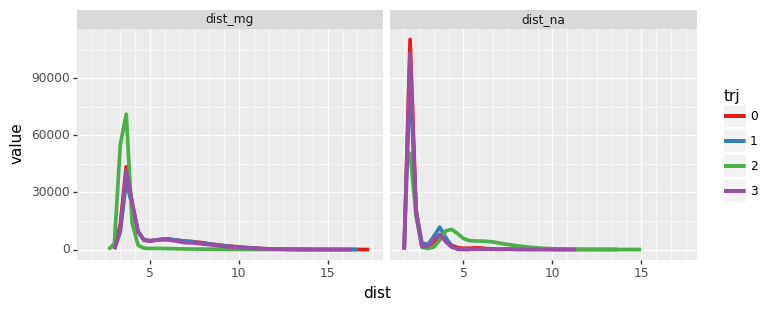

<ggplot: (8739823684037)>

In [12]:
f_summary_actcha= summary_featurizer(directory='active_charged')
#f_summary_actcha.add_trajs()
f_summary_actcha.get_output(filename='f_summary_actcha.pkl')
f_summary_actcha.summarise()

In [13]:
#summary_features1 = f1.get_output(skip=1000)
##hist1(summary_features1)

In [14]:
## do detailed interaction fprints
bound_cutoffs = {
    'mg_dists':{'direct':.2,'wwm':.4}, 
    'na_dists':{'direct':.3, 'wwm':.4}}

In [91]:
f_res_actcha = res_featurizer(directory='active_charged')
#f_res_actcha.add_trajs()
f_res_actcha.get_output(filename='f_res_actcha.pkl')

Unique PDB file identified top_ac_prot_sod_mg.pdb
mindist to mg has dim 283
mindist to na has dim 283
reading pickled data from f_res_actcha.pkl
data read for 4 trajectories, 566 dimensions


In [92]:
#f_res_actcha.output[0].shape
xx_mg,xx_na=f_res_actcha.get_contacts(bound_cutoffs)

In [93]:
xx_mg.head()

,MET65,TYR91,ARG95,TYR96,THR97,LYS98,LYS100,THR101,THR103,GLN124,...,PHE338,LEU339,ASP340,GLU341,ASN342,PHE343,LYS344,ARG345,CYS346,PHE347
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
#tk1_actcha = f_res_actcha.get_tica(filename='tica_res_atcha.pkl',lagtime=20)
tk2_actcha = f_res_actcha.get_tica(filename='tica10_res_atcha.pkl',lagtime=10)# ,forcecalculate=True)

reading pickled data from tica10_res_atcha.pkl
data read for 4 trajectories, 30 dimensions


In [19]:
def subsetter(data, slicer):
    if isinstance(slicer,int):
        slicer=slice(None,None,slicer)
    newdata= [trj[slicer] for trj in data]
    for i,trj in enumerate(newdata):
        l,d = trj.shape
        print(f'traj {i}: length: {len(data[i])} -> {l}, dim={d}')
    return newdata
subset = slice(None,None,30)


### Calculates ion features, and sums up the bound

In [20]:
f_ion_actcha = ion_featurizer(directory='active_charged')
#f_ion_actcha.add_trajs()
f_ion_actcha.get_output(filename='f_ion_actcha.pkl');

Unique PDB file identified top_ac_prot_sod_mg.pdb
mindist from mg has dim 37
mindist from na has dim 37
reading pickled data from f_ion_actcha.pkl
data read for 4 trajectories, 74 dimensions


In [21]:
bds_atcha = f_ion_actcha.get_bound_counts(bound_cutoffs)

In [22]:
#tk_st = np.vstack(tk1)
#df1=pd.DataFrame(bds_st, columns=['mg_d','mg_wwm','na_d','na_wwm'])
#df2=pd.DataFrame(tk_st)
#df3 = pd.concat([df1, df2], axis=1, sort=False)
#df3_melt = df3[['mg_wwm','na_d',0,1]].melt(id_vars=[0,1]).rename(index=str, columns={0:'tic0',1:'tic1'})
#bds_small = subsetter(bds,subset)

### Density clustering with PAk/TOW-NN

In [24]:
tk1_actcha = tk2_actcha
clustering=dp.cluster_UDP(8., tk1_actcha, sens=1.5, coring=False, stride=7)

here
Computing distances
fortran density estimation
1.5
fortran clustering
Done!
71.67919850349426 s
now post-processing
110.18321180343628
finished postprocessing


In [25]:
#def getdf(clustering, others=None):
#    ctraj = clustering.get_core_traj()
#    ctraj_stack = np.concatenate(ctraj)
#    iscore=ctraj_stack==clustering.frame_cl
#    trj_ID = [np.repeat(i,repeats=len(t)) for i,t in enumerate(ctraj)]
#    
#    dfo = pd.DataFrame(
#        {'iscore':iscore, 
#         'fc':clustering.frame_cl, 
#         'ctraj':ctraj_stack,
#         'trj_ID':np.concatenate(trj_ID)
#         })
#    if others:
#        dflist = [dfo]+others
#        return pd.concat(dflist,axis=1)
#    else:
#        return dfo

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


In [26]:
trj_ID = [np.repeat(i,repeats=len(t)) for i,t in enumerate(tk1_actcha)]
dtraj_actcha = [(clustering.frame_cl)[np.concatenate(trj_ID)==i]     for i in range(len(tk2_actcha))]
print(f'number of micros {len(np.unique(np.concatenate(dtraj_actcha)))}')

In [177]:
print(f'number of micros {len(np.unique(np.concatenate(dtraj_actcha)))}')

number of micros 2791


In [178]:
#df_tk = pd.DataFrame(np.vstack(tk1_actcha), columns=[f'tic{i}' for i in range(np.vstack(tk1_actcha).shape[1])])
#df_bds = pd.DataFrame(np.vstack(bds_atcha), columns=['mg_d','mg_wwm','na_d','na_wwm'])
#dfo=getdf(clustering,others=[df_tk, df_bds])
#dfo_core = dfo[dfo['iscore']];

In [28]:
#gg = ( 
#    ggplot(dfo, aes(x='tic0',y='tic1',color='ctraj',size='iscore')) + 
#    geom_point() + 
#    #facet_wrap('variable',nrow=2) + 
#    #scale_x_continuous(minor_breaks=5)+
#    #scale_color_gradient(low='blue', high='red')+
#    #scale_color_brewer(type='qual',palette='Set1')+
#    theme(figure_size=(4, 4)))
#gg

In [179]:
#dfo_core.groupby('ctraj').size()
#dxx2.groupby(['clusterh','core']).size()
#dxx3 = dxx2[dxx2['core']];
#dxx3.groupby('cluster').size()

In [31]:
#summaries = ['mean','std',percentile(25),percentile(75),'count','max']
#summa=dfo_core.groupby('ctraj').agg({'mg_wwm':summaries, 'na_d':summaries})
#summa.columns = ['_'.join(col).strip() for col in summa.columns.values]
#summa.reset_index(inplace=True)
#summa_melt=summa[['ctraj','mg_wwm_mean','na_d_mean','na_d_count']].melt(id_vars=['ctraj','na_d_count'])
#summa_melt

In [32]:
#summa['ctraj']=summa['ctraj'].astype('category')
#gg = (
#    ggplot(summa, aes(x='mg_wwm_mean',y='na_d_mean',color='mg_wwm_mean',size='na_d_count')) + 
#    geom_point() + 
#    #facet_wrap('variable',nrow=2) + 
#    #scale_x_continuous(minor_breaks=5)+
#    #scale_color_gradient(low='blue', high='red')+
#    #scale_color_brewer(type='qual',palette='Set1')+
#    theme(figure_size=(4, 4)))
#gg

In [33]:
### Do forst MSM 
#ctraj_actcha = clustering.get_core_traj()
#ctraj_actcha

In [34]:
#clustering.frame_cl.max()

In [35]:
#len(np.unique(np.concatenate(ctraj_actcha)))

In [36]:
its = pyemma.msm.timescales_msm(dtraj_actcha, lags=np.arange(1,20,2), nits=10, n_jobs=-1)

/home/davide/miniconda3/lib/python3.6/site-packages/msmtools/estimation/api.py:950: NotConvergedWarning: Reversible transition matrix estimation didn't converge.
  result = sparse.mle_trev.mle_trev(C, **kwargs)


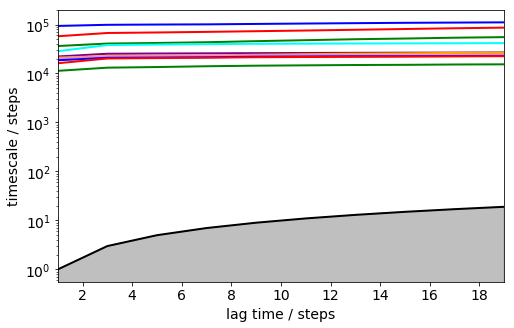

In [37]:
plt.figure(figsize=(8,5))
matplotlib.rcParams.update({'font.size': 14})
pyemma.plots.plot_implied_timescales(its, show_mean=False, ylog=True,  linewidth=2)

In [200]:
msm_lag = 20
M_actcha = pyemma.msm.estimate_markov_model(dtraj_actcha, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  0.9974433893352812
fraction of counts used =  0.9984386409184831


(-0.5, 20)

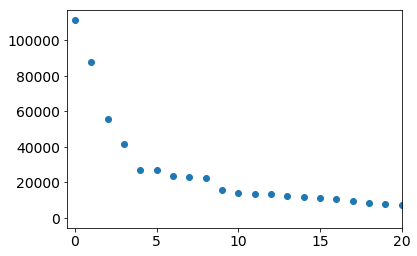

In [201]:
plt.plot(M_actcha.timescales(),linewidth=0,marker='o')
plt.xlim(-0.5,20)

(<Figure size 504x504 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e619e27f0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f2e3d2f6358>]], dtype=object))

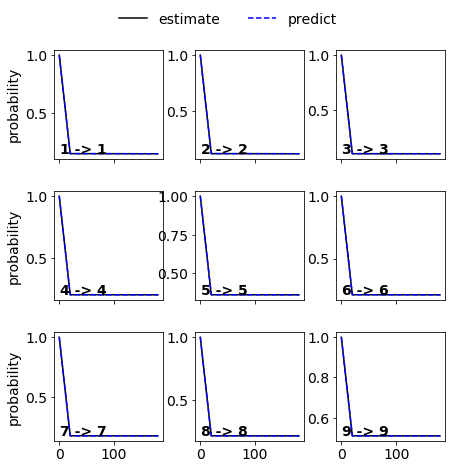

In [203]:
#M = pyemma.msm.bayesian_markov_model(dtraj_actcha, msm_lag)
ck_actcha = M_actcha.cktest(10, mlags=10, err_est=False)
pyemma.plots.plot_cktest(ck_actcha, 
                 diag=True, 
                 figsize=(7,7), 
                 layout=(3,3), 
                 padding_top=0.1, 
                 y01=False, 
                 padding_between=0.3)

In [204]:
hmm_actcha = M_actcha.coarse_grain(10)

19-12-18 07:47:58 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[21] WARNING  Requested coarse-grained model with 10 metastable states at lag=20. The ratio of relaxation timescales between 10 and 11 states is only 1.4643389468861823 while we recommend at least 1.5. It is possible that the resulting HMM is inaccurate. Handle with caution.


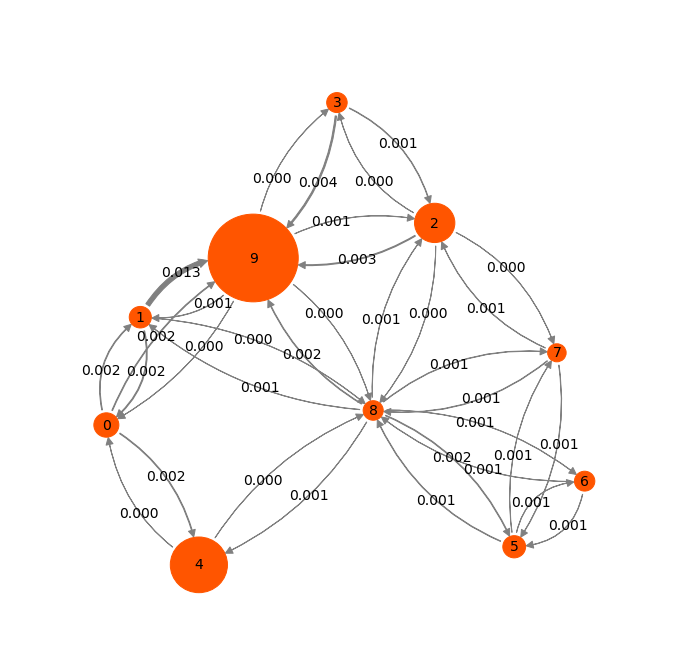

In [206]:
plt_actcha = pyemma.plots.plot_markov_model(hmm_actcha, arrow_label_format='%.3f')

In [234]:
def getfull_df_char(hmm, M,dtraj,bds):
    ### characterize states
    ### index translation
    setIDX = pd.DataFrame({
        'microstate':M.active_set,
        'activemicrostate':np.arange(len(M.active_set)),
        'hmm_macrostate':hmm.metastable_assignments})
    #setIDX.head()
    
    print(f'dtrajs have {np.concatenate(dtraj).max()} states')
    print(f'active set has {len(M.active_set)} states')
    print(f'metastable_ass assigns {len(hmm.metastable_assignments)} states')
    
    ## each active microstate is assigned to a macrostate here:
    dfo = pd.DataFrame({
        'dtraj': np.concatenate(dtraj),
        'trj_ID': np.concatenate(
            [np.repeat(i,repeats=len(t)) for i,t in enumerate(dtraj)]),
        'trj_frame': np.concatenate(
            [np.arange(len(t)) for i,t in enumerate(dtraj)])})
    #dfo.head()
    
    df_bds = pd.DataFrame(np.vstack(bds), columns=['mg_d','mg_wwm','na_d','na_wwm'])
    dfo2 = dfo.join(setIDX.set_index('microstate'),on='dtraj')
    dfo3 = pd.concat([dfo2, df_bds],axis=1)
    
    summaries = ['mean','std',percentile(15),percentile(50),percentile(85),'count','max']
    summa=dfo3.groupby('hmm_macrostate').agg({'mg_wwm':summaries, 'na_d':summaries})
    summa.columns = ['_'.join(col).strip() for col in summa.columns.values]
    #summa.reset_index(inplace=True)
    #summa_melt=summa[['ctraj','mg_wwm_mean','na_d_mean','na_d_count']].melt(id_vars=['ctraj','na_d_count'])
    #summa_melt
    
    #summa
    if True: ## using median
        mg_int = list(np.array(['blue','purple'])[summa['mg_wwm_percentile_50'].astype('int')])
        na_int = list(np.array(['blue','purple','red'])[summa['na_d_percentile_50'].astype('int')])
    else: ## using mean
        mg_int = list(np.array(['blue','purple'])[summa['mg_wwm_mean'].round(0).astype('int')])
        na_int = list(np.array(['blue','purple','red'])[summa['na_d_mean'].round(0).astype('int')])
 
    
    return summa, dfo3, mg_int, na_int


In [235]:
summa_actcha, dfo3_actcha, mg_int_actcha, na_int_actcha = getfull_df_char(
    hmm_actcha, M_actcha,dtraj_actcha,bds_atcha)

dtrajs have 2790 states
active set has 2708 states
metastable_ass assigns 2708 states


In [216]:
summa_actcha

,mg_wwm_mean,mg_wwm_std,mg_wwm_percentile_15,mg_wwm_percentile_50,mg_wwm_percentile_85,mg_wwm_count,mg_wwm_max,na_d_mean,na_d_std,na_d_percentile_15,na_d_percentile_50,na_d_percentile_85,na_d_count,na_d_max
hmm_macrostate,,,,,,,,,,,,,,
0.0,0.571015,0.619694,0,1,1,23474,4,0.615319,0.836691,0,0,1,23474,5
1.0,0.517799,0.653355,0,0,1,18175,4,0.936066,0.825468,0,1,2,18175,5
2.0,0.370143,0.575725,0,0,1,53501,4,1.350797,0.920872,0,1,2,53501,6
3.0,0.387008,0.615195,0,0,1,15240,3,1.346063,0.801389,1,1,2,15240,4
4.0,1.210831,0.623346,1,1,2,128520,6,0.609477,0.743245,0,0,1,128520,5
5.0,0.568428,0.579550,0,1,1,7380,3,1.972222,0.872034,1,2,3,7380,5
6.0,0.290374,0.514631,0,0,1,15790,3,1.641482,0.765799,1,1,2,15790,5
7.0,0.353169,0.529512,0,0,1,13713,3,1.397214,0.637199,1,1,2,13713,4
8.0,0.385219,0.566034,0,0,1,13382,3,1.393588,0.714648,1,1,2,13382,4


In [258]:
def get_contact_prob(dfo3, xx, cutoff_prob, cutoff_label, ion_tag):
    dfo4 = pd.concat([dfo3,xx],axis=1)
    dfo_contacts = dfo4.groupby('hmm_macrostate').agg('mean')
    high_residues = xx.columns[np.where(dfo_contacts[xx.columns].max()>cutoff_prob)[0]]
    
    yy= dfo_contacts[high_residues]
    labels=[]
    for n,g in yy.groupby('hmm_macrostate'):
        list_res = np.array(g.columns[np.where(g>cutoff_label)[1]])
        label='/'.join(list_res)
        labels.append( f'{int(n)}' + (f'-{ion_tag}:{label}' if label else ''))
    
    return (yy).round(2), labels


#desc_cutoffs = {
#    'mg': {'prob':0.01, 'label':0.2},
#    'na': {'prob':0.01, 'label':0.1}}

def characterize_contacts(dfo3, xx_mg, xx_na, desc_cutoffs):
    #yy_mg, lab_mg = get_contact_prob(dfo3, xx_mg,0.01,0.2,'Mg')
    #yy_na, lab_na = get_contact_prob(dfo3, xx_na,0.1,0.1,'Na')
    yy_mg, lab_mg = get_contact_prob(dfo3, xx_mg,
                                     desc_cutoffs['mg']['prob'],
                                     desc_cutoffs['mg']['label'],'Mg')
    yy_na, lab_na = get_contact_prob(dfo3, xx_na,      
                                     desc_cutoffs['na']['prob'],
                                     desc_cutoffs['na']['label'],'Na')

    df_labs = pd.DataFrame({'mg':lab_mg,'na':lab_na})
    return yy_mg, lab_mg, yy_na, lab_na, df_labs


In [259]:
#yy_mg, lab_mg = get_contact_prob(dfo3_actcha, xx_mg,0.01,0.2,'Mg')
#yy_na, lab_na = get_contact_prob(dfo3_actcha, xx_na,0.1,0.1,'Na')
#df_labs = pd.DataFrame({'mg':lab_mg,'na':lab_na})

In [289]:
desc_cutoffs = {
    'mg': {'prob':0.01, 'label':0.1},
    'na': {'prob':0.01, 'label':0.05}}


desc_cutoffs = {
    'mg': {'prob':0.01, 'label':0.1},
    'na': {'prob':0.01, 'label':0.1}}


In [290]:
yy_mg_actcha, lab_mg_actcha, yy_na_actcha, lab_na_actcha, df_labs_actcha = characterize_contacts(
    dfo3_actcha, xx_mg, xx_na,desc_cutoffs)
df_labs_actcha

,mg,na
0,0-Mg:ASP216/GLU310,0
1,1-Mg:ASP216/GLU310,1-Na:ASP147/GLU229/PHE347
2,2-Mg:ASP216,2-Na:ASP147/ASP216/GLY325/SER329/PHE347
3,3,3-Na:ASP147/GLY325/SER329
4,4-Mg:ASP147,4
5,5-Mg:ASP216/GLU310,5-Na:ASP114/ASN150/SER154/ASP177/ASP216/GLU229...
6,6,6-Na:ASP114/ASN150/SER154/ASP216/GLU310/PHE347
7,7-Mg:GLU310,7-Na:ASP114/ASN150/SER154/ASP216/GLY325/SER329
8,8-Mg:ASP216/GLU310,8-Na:ASP147/ASN150/GLU310/PHE347
9,9-Mg:ASP216/GLU310,9-Na:ASP114/ASP147/SER154


In [ ]:
#ASP144, ASN150, SER154 -> allosteric site
#ASP147 -> orthosteric

#ASP216 - > EC2, GLU310 ->EC3
#GLU229 -> EC2

# 325, 329 -> TM6

In [ ]:
#### characterize states
#
#setIDX = pd.DataFrame({
#    'microstate':M.active_set,
#    'activemicrostate':np.arange(len(M.active_set)),
#    'hmm_macrostate':hmm.metastable_assignments
#})
#
#setIDX.head()

In [ ]:
#print(f'dtrajs have {np.concatenate(dtraj_actcha).max()} states')
#print(f'active set has {len(M.active_set)} states')
#print(f'metastable_ass assigns {len(hmm.metastable_assignments)} states')

In [46]:
### each active microstate is assigned to a macrostate here:
#dfo = pd.DataFrame({
#    'dtraj': np.concatenate(dtraj_actcha),
#    'trj_ID': np.concatenate(
#        [np.repeat(i,repeats=len(t)) for i,t in enumerate(dtraj_actcha)]),
#    'trj_frame': np.concatenate(
#        [np.arange(len(t)) for i,t in enumerate(dtraj_actcha)]),
#    
#})
##dfo.head()

In [47]:
#df_bds = pd.DataFrame(np.vstack(bds_atcha), columns=['mg_d','mg_wwm','na_d','na_wwm'])
#dfo2 = dfo.join(setIDX.set_index('microstate'),on='dtraj')
#dfo3 = pd.concat([dfo2, df_bds],axis=1)

In [ ]:
#dfo3.head()

In [ ]:
#summaries = ['mean','std',percentile(15),percentile(50),percentile(85),'count','max']
#summa=dfo3.groupby('hmm_macrostate').agg({'mg_wwm':summaries, 'na_d':summaries})
#summa.columns = ['_'.join(col).strip() for col in summa.columns.values]
#summa.reset_index(inplace=True)
#summa_melt=summa[['ctraj','mg_wwm_mean','na_d_mean','na_d_count']].melt(id_vars=['ctraj','na_d_count'])
#summa_melt
#summa

In [246]:
def plot_annotated( hmm, plt, mg_int, na_int, lab_mg, lab_na):
    
    pyemma.plots.plot_markov_model(
        hmm, 
        pos= plt[1], 
        state_colors=mg_int,
        state_labels=lab_mg,
        #state_colors=summa['mg_wwm_mean']/summa['mg_wwm_mean'].max(),
        arrow_label_format='%.3f')

    pyemma.plots.plot_markov_model(
        hmm, 
        pos= plt[1], 
        state_colors=na_int,
        state_labels=lab_na,
        #state_colors=summa['mg_wwm_mean']/summa['mg_wwm_mean'].max(),
        arrow_label_format='%.3f', horizontalalignment='left')

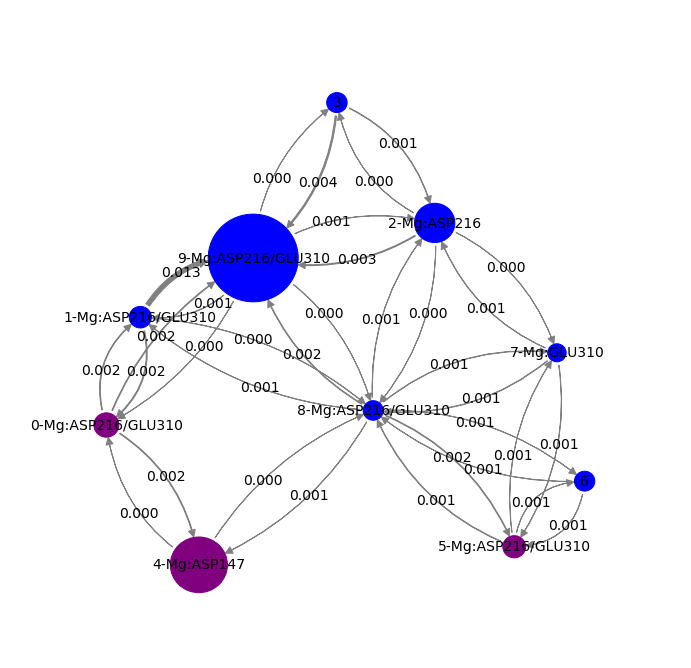

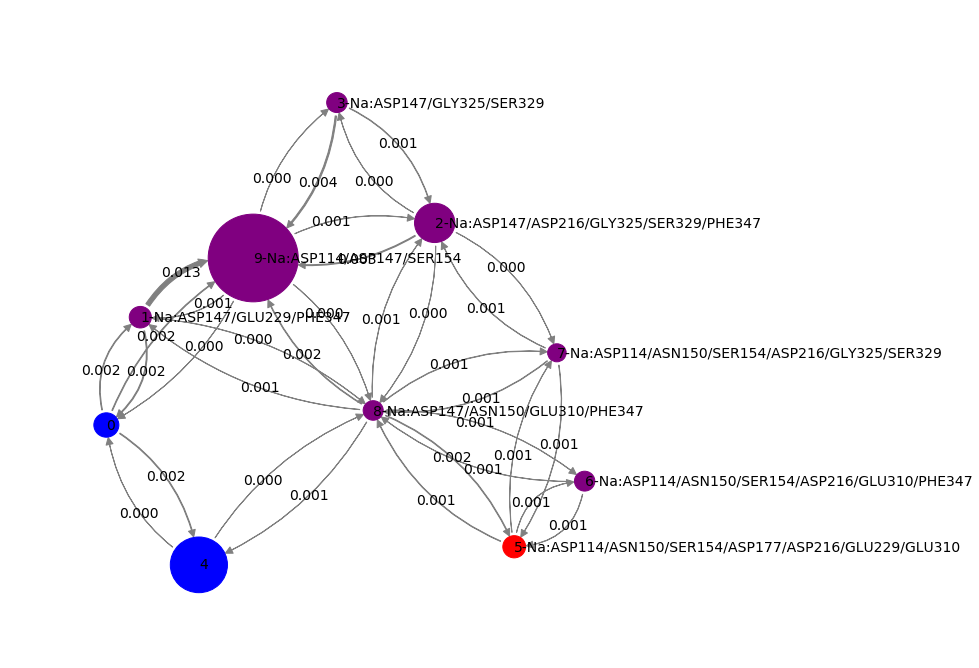

In [292]:
plot_annotated( hmm_actcha, plt_actcha, mg_int_actcha, na_int_actcha, lab_mg_actcha, lab_na_actcha)

In [217]:
#
#mg_int = list(np.array(['blue','purple'])[summa['mg_wwm_percentile_50'].astype('int')])
#na_int = list(np.array(['blue','purple','red'])[summa['na_d_percentile_50'].astype('int')])
#
#
#pyemma.plots.plot_markov_model(
#    hmm, 
#    pos= plt_actcha[1], 
#    state_colors=mg_int,
#    state_labels=lab_mg,
#    #state_colors=summa['mg_wwm_mean']/summa['mg_wwm_mean'].max(),
#    arrow_label_format='%.3f')
#
#pyemma.plots.plot_markov_model(
#    hmm, 
#    pos= plt_actcha[1], 
#    state_colors=na_int,
#    state_labels=lab_na,
#    #state_colors=summa['mg_wwm_mean']/summa['mg_wwm_mean'].max(),
#    arrow_label_format='%.3f', horizontalalignment='left')

In [81]:
def mysample(dfo3, nclust, nsize):
    '''
    extracts a randp, sample of a HMM cluster from the trajectories
    '''
    nclust=9
    nsize=200
    samples = np.random.choice(np.where(dfo3['hmm_macrostate']==nclust)[0],size=nsize)
    yy=dfo3.loc[samples].groupby('trj_ID')
    frames=[]
    frames_pyemma=[]
    for i in np.unique(dfo3['trj_ID']):
        try:
            zz=yy.get_group(i)
            for f in zz['trj_frame'].values:
                frames_pyemma.append([[i,f]])
            frames.append(zz['trj_frame'].values)
        except:
            print(f'no frames in trajectory ID {i}')
            frames.append([])
        
    return frames, np.concatenate(frames_pyemma)

In [82]:
frames, frames_p = mysample(dfo3, 9, 100)

no frames in trajectory ID 2


(200, 2)

In [ ]:
gg = ( ggplot(df3_melt.iloc[::100], aes(x='tic0',y='tic1',color='value')) + 
      geom_point(size=.4) + 
      facet_wrap('variable') + 
      #scale_x_continuous(minor_breaks=5)+
      scale_color_gradient(low='blue', high='red')+
      theme(figure_size=(8, 3))
      )
gg

In [ ]:
        #f_ion_actcha.summarise_bound_counts()
        bounds = bds
        df = []
        for i, trj in enumerate(bounds):
            q1=pd.DataFrame(bds[0],columns=['mg_dir','mg_wwm','na_dir','na_wwm'])
            q2 = q1.groupby(['mg_wwm','na_wwm']).agg({'mg_wwm':'count'})
            df.append(q2)
        alldata = pd.concat(df, axis=0, 
                            keys=[f'{i}' for i in range(len(bounds))],
                            names=['trj','mg_wwm1','na_wwm1']).reset_index()


In [ ]:
f_full_atcha = full_featurizer(directory='active_charged')

# Active Neutral

Unique PDB file identified top_an_prot_sod_mg.pdb
reading pickled data from f_summary_actneu.pkl
data read for 4 trajectories, 2 dimensions
0 158106 frames, Mg min: 3.07 	 Na min: 2.0
1 152171 frames, Mg min: 3.05 	 Na min: 2.0
2 223392 frames, Mg min: 3.06 	 Na min: 2.0
3 238735 frames, Mg min: 3.08 	 Na min: 2.0


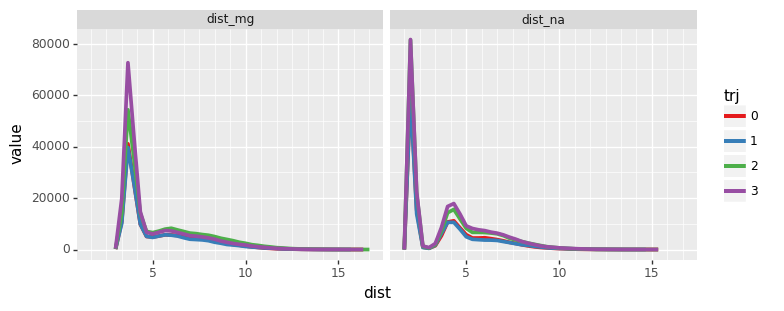

<ggplot: (8739785737627)>

In [180]:
f_summary_actneu = summary_featurizer(directory='active_neutral')
#f_summary_actneu.add_trajs()
f_summary_actneu.get_output(skip=1000, filename='f_summary_actneu.pkl')
f_summary_actneu.summarise()

In [182]:
f_res_actneu = res_featurizer(directory='active_neutral')
f_res_actneu.add_trajs()
f_res_actneu.get_output(filename='f_res_actneu.pkl')

Unique PDB file identified top_an_prot_sod_mg.pdb
mindist to mg has dim 283
mindist to na has dim 283
traj_an_red_3.xtc
traj_an_red_4.xtc
traj_an_red_1.xtc
traj_an_red_2.xtc


saving data to f_res_actneu.pkl


In [183]:
xx_actneu_mg,xx_actnau_na=f_res_actneu.get_contacts(bound_cutoffs)

In [184]:
tk2_actneu = f_res_actneu.get_tica(filename='tica10_res_neuha.pkl',lagtime=10)# ,forcecalculate=True)

saving data to tica10_res_neuha.pkl


In [185]:
f_ion_actneu = ion_featurizer(directory='active_neutral')
f_ion_actneu.add_trajs()
f_ion_actneu.get_output(filename='f_ion_actneu.pkl');

Unique PDB file identified top_an_prot_sod_mg.pdb
mindist from mg has dim 37
mindist from na has dim 37
traj_an_red_3.xtc
traj_an_red_4.xtc
traj_an_red_1.xtc
traj_an_red_2.xtc


saving data to f_ion_actneu.pkl


In [186]:
bds_actneu = f_ion_actneu.get_bound_counts(bound_cutoffs)

### Active Neutral: Density clustering with PAk/TOW-NN

In [190]:
tk1_actneu = tk2_actneu
clustering_actneu=dp.cluster_UDP(8., tk1_actneu, sens=1.5, coring=False, stride=9)

here
Computing distances
fortran density estimation
1.5
fortran clustering
Done!
46.2901828289032 s
now post-processing
131.66900062561035
finished postprocessing


In [192]:
trj_ID_actneu = [np.repeat(i,repeats=len(t)) for i,t in enumerate(tk1_actneu)]
dtraj_actneu = [(clustering_actneu.frame_cl)[np.concatenate(trj_ID_actneu)==i]     for i in range(len(tk2_actneu))]
print(f'number of micros {len(np.unique(np.concatenate(dtraj_actneu)))}')

number of micros 2738


### Do Markov modeling on microstates

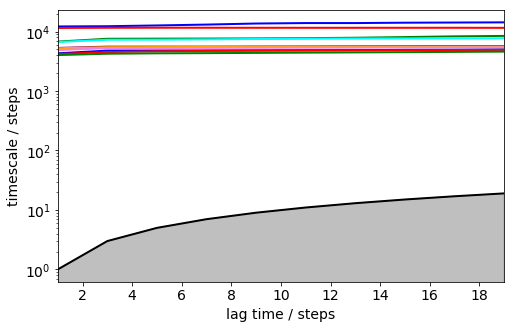

In [194]:
its_actneu = pyemma.msm.timescales_msm(dtraj_actneu, lags=np.arange(1,20,2), nits=10, n_jobs=-1)
plt.figure(figsize=(8,5))
matplotlib.rcParams.update({'font.size': 14})
pyemma.plots.plot_implied_timescales(its_actneu, show_mean=False, ylog=True,  linewidth=2)

In [197]:
msm_lag = 20
M_actneu = pyemma.msm.estimate_markov_model(dtraj_actneu, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  0.9974433893352812
fraction of counts used =  0.9984386409184831


(-0.5, 30)

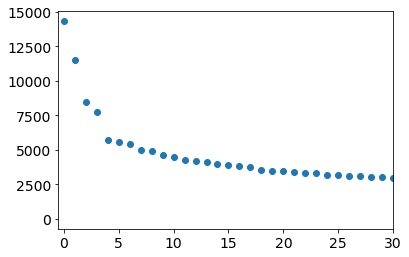

In [199]:
plt.plot(M_actneu.timescales(),linewidth=0,marker='o')
plt.xlim(-0.5,30)

In [ ]:
#M = pyemma.msm.bayesian_markov_model(dtraj_actcha, msm_lag)
ck_actneu = M_actneu.cktest(5, mlags=10, err_est=False)
pyemma.plots.plot_cktest(ck_actneu, 
                 diag=True, 
                 figsize=(7,7), 
                 layout=(2,2), 
                 padding_top=0.1, 
                 y01=False, 
                 padding_between=0.3)

In [224]:
hmm_actneu = M_actneu.coarse_grain(5)

19-12-18 08:19:23 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[22] WARNING  Requested coarse-grained model with 5 metastable states at lag=20. The ratio of relaxation timescales between 5 and 6 states is only 1.3506287926725808 while we recommend at least 1.5. It is possible that the resulting HMM is inaccurate. Handle with caution.


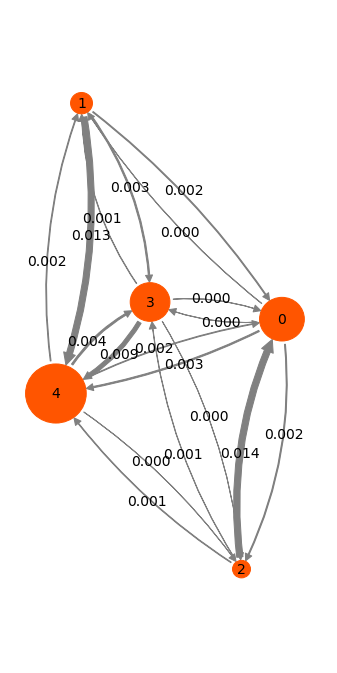

In [239]:
plt_actneu = pyemma.plots.plot_markov_model(hmm_actneu, arrow_label_format='%.3f')

In [237]:
summa_actneu, dfo3_actneu, mg_int_actneu, na_int_actneu = getfull_df_char(
    hmm_actneu, M_actneu,dtraj_actneu,bds_actneu)

dtrajs have 2737 states
active set has 2731 states
metastable_ass assigns 2731 states


In [238]:
summa_actneu

,mg_wwm_mean,mg_wwm_std,mg_wwm_percentile_15,mg_wwm_percentile_50,mg_wwm_percentile_85,mg_wwm_count,mg_wwm_max,na_d_mean,na_d_std,na_d_percentile_15,na_d_percentile_50,na_d_percentile_85,na_d_count,na_d_max
hmm_macrostate,,,,,,,,,,,,,,
0.0,0.365340,0.561322,0,0,1,189366,4,0.589155,0.741682,0,0,1,189366,5
1.0,0.399674,0.583216,0,0,1,47186,4,0.473636,0.648074,0,0,1,47186,4
2.0,0.267736,0.507987,0,0,1,31038,4,0.785650,0.788300,0,1,2,31038,4
3.0,0.369698,0.566744,0,0,1,149679,4,0.647679,0.796206,0,0,1,149679,5
4.0,0.414001,0.592290,0,0,1,353929,4,0.609176,0.744872,0,0,1,353929,5


In [291]:

yy_mg_actneu, lab_mg_actneu, yy_na_actneu, lab_na_actneu, df_labs_actneu = characterize_contacts(
    dfo3_actneu, xx_actneu_mg, xx_actnau_na,desc_cutoffs)

df_labs_actneu

,mg,na
0,0,0-Na:PHE347
1,1-Mg:GLU310,1
2,2,2-Na:ASP216/GLU229
3,3-Mg:ASP216,3
4,4-Mg:GLU310,4


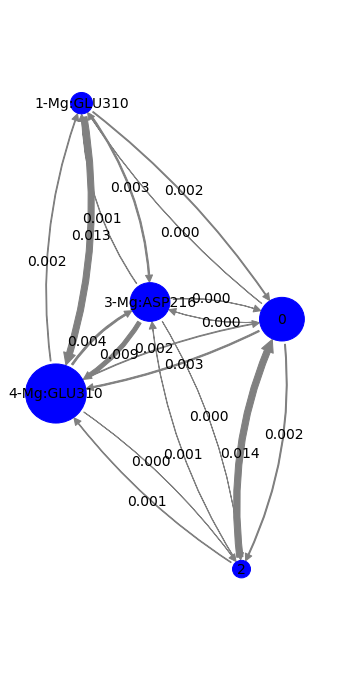

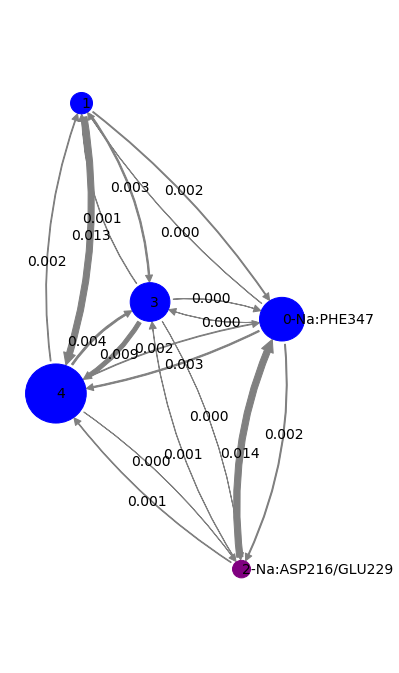

In [293]:
plot_annotated( hmm_actneu, plt_actneu, mg_int_actneu, na_int_actneu, lab_mg_actneu, lab_na_actneu)

# Inactive

Unique PDB file identified top_ina_prot_sod_mg.pdb
reading pickled data from f_summary_inactive.pkl
data read for 6 trajectories, 2 dimensions
0 65453 frames, Mg min: 3.08 	 Na min: 2.0
1 78874 frames, Mg min: 3.07 	 Na min: 2.0
2 144013 frames, Mg min: 3.07 	 Na min: 2.0
3 149074 frames, Mg min: 3.06 	 Na min: 2.0
4 97009 frames, Mg min: 3.09 	 Na min: 2.0
5 164824 frames, Mg min: 3.03 	 Na min: 2.0


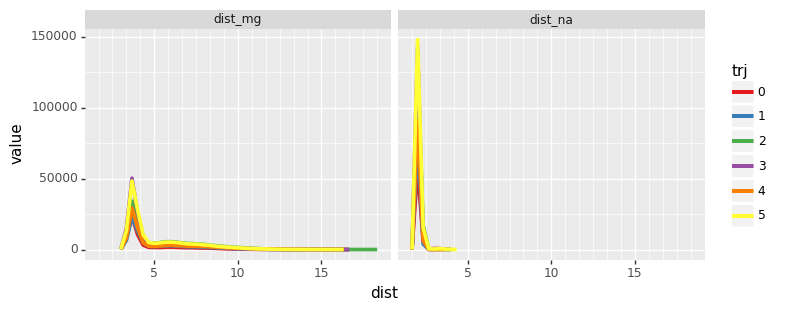

<ggplot: (-9223363297046103278)>

In [181]:
f_summary_inactive = summary_featurizer(directory='inactive')
#f_summary_inactive.add_trajs()
f_summary_inactive.get_output(skip=1000,filename='f_summary_inactive.pkl')
f_summary_inactive.summarise()

In [ ]:
f_res_inactive = res_featurizer(directory='inactive')
f_res_actcha.add_trajs()
f_res_inactive.get_output(filename='f_res_inactive.pkl')

Unique PDB file identified top_ina_prot_sod_mg.pdb
mindist to mg has dim 283
mindist to na has dim 283
traj_ac_red_3.xtc
traj_ac_red_1.xtc
traj_ac_red_2.xtc
traj_ac_red_4.xtc


In [ ]:
xx_inactive_mg,xx_inactive_na=f_res_inactive.get_contacts(bound_cutoffs)

In [ ]:
tk2_inactive = f_res_inactive.get_tica(filename='tica10_res_inactive.pkl',lagtime=10)# ,forcecalculate=True)

In [ ]:
f_ion_inactive = ion_featurizer(directory='inactive')
f_ion_inactive.add_trajs()
f_ion_inactiveu.get_output(filename='f_ion_inactive.pkl');

In [ ]:
bds_inactive = f_ion_inactive.get_bound_counts(bound_cutoffs)

In [ ]:
tk1_inactive = tk2_inactive
clustering_inactive=dp.cluster_UDP(8., tk1_inactive, sens=1.5, coring=False, stride=9)

In [ ]:
trj_ID_inactive = [np.repeat(i,repeats=len(t)) for i,t in enumerate(tk1_inactive)]
dtraj_inactive = [(clustering_inactive.frame_cl)[np.concatenate(trj_ID_inactive)==i]
                   for i in range(len(tk2_inactive))]
print(f'number of micros {len(np.unique(np.concatenate(dtraj_actneu)))}')

In [ ]:
its_inactive = pyemma.msm.timescales_msm(dtraj_inactive, lags=np.arange(1,20,2), nits=10, n_jobs=-1)
plt.figure(figsize=(8,5))
matplotlib.rcParams.update({'font.size': 14})
pyemma.plots.plot_implied_timescales(its_inactive, show_mean=False, ylog=True,  linewidth=2)

In [ ]:
msm_lag = 20
M_inactive = pyemma.msm.estimate_markov_model(dtraj_inactive, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)